# Audio Inference and Inspection

In [1]:
import sys
from pathlib import Path
import torch
import torchaudio
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

ROOT = Path('.').resolve()
sys.path.insert(0, str(ROOT))

from src.trainer import AudioCodecModule
from src import config as cfg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Load Mel-Spectrogram

In [2]:
test_files = list(Path("data/processed_norm/test-clean").rglob("*.pt"))
test_file = random.choice(test_files)

mel_original = torch.load(test_file).float()
if mel_original.dim() == 2:
    mel_original = mel_original.unsqueeze(0)
if mel_original.dim() == 3:
    mel_original = mel_original.unsqueeze(1)

print(f"Selected: {test_file}")
print(f"Mel shape: {mel_original.shape}")
print(f"Duration (frames): {mel_original.shape[-1]}")
print(f"Time (sec): {mel_original.shape[-1] * 256 / 16000:.2f}s")

Selected: data/processed_norm/test-clean/4970/29093/4970-29093-0012.pt
Mel shape: torch.Size([1, 1, 80, 545])
Duration (frames): 545
Time (sec): 8.72s


## Visualize Original

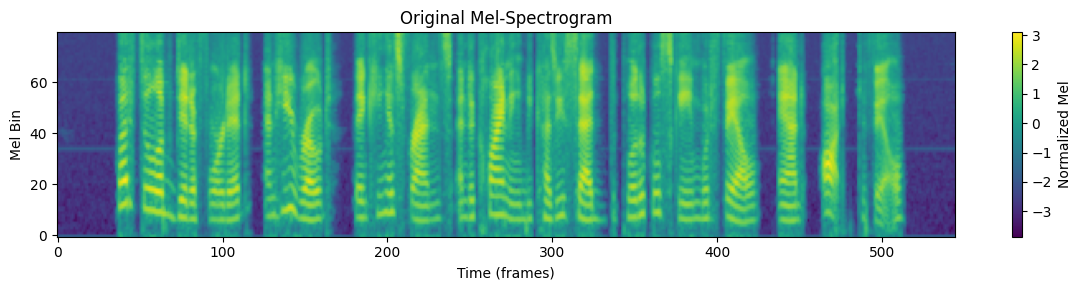

In [3]:
plt.figure(figsize=(12, 3))
plt.imshow(mel_original[0, 0].cpu().numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Mel')
plt.xlabel('Time (frames)')
plt.ylabel('Mel Bin')
plt.title('Original Mel-Spectrogram')
plt.tight_layout()
plt.show()

## Load Model

In [4]:
checkpoint_path = "checkpoints/last.ckpt"
print(f"Loading: {checkpoint_path}")

model = AudioCodecModule.load_from_checkpoint(checkpoint_path, map_location=device)
model.eval()
model.to(device)

print(f"Model loaded successfully")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading: checkpoints/last.ckpt


An error occurred while trying to fetch google/ddpm-ema-celebahq-256: google/ddpm-ema-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loaded pretrained UNet from google/ddpm-ema-celebahq-256
UNet expects: 3 channels, 256x256 size
Model loaded successfully
Total parameters: 113,681,969


## Run Inference

In [5]:
mel = mel_original.to(device)

with torch.no_grad():
    t = torch.zeros(mel.size(0), dtype=torch.long, device=device)
    mel_reconstructed, _ = model.model(mel, t)

print(f"Reconstructed shape: {mel_reconstructed.shape}")
print(f"Reconstruction complete")

Reconstructed shape: torch.Size([1, 80, 80, 545])
Reconstruction complete


## Compare Results

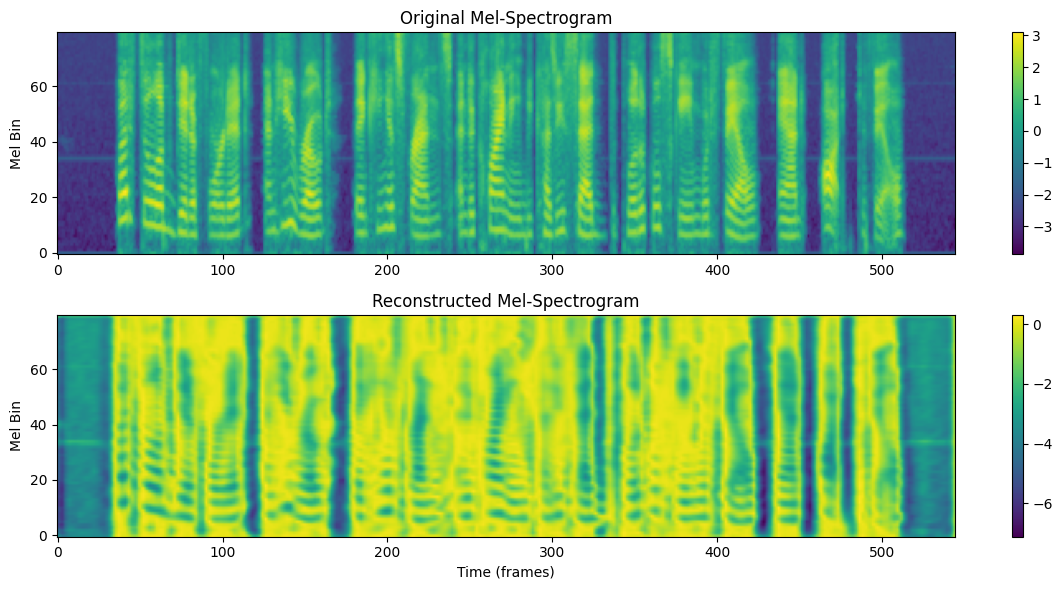

MSE: 2.976328


In [6]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

mel_orig_np = mel_original[0, 0].cpu().numpy()
mel_recon_np = mel_reconstructed[0, 0].cpu().numpy()

im1 = axes[0].imshow(mel_orig_np, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Original Mel-Spectrogram')
axes[0].set_ylabel('Mel Bin')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(mel_recon_np, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Reconstructed Mel-Spectrogram')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Mel Bin')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

mse = np.mean((mel_orig_np - mel_recon_np) ** 2)
print(f"MSE: {mse:.6f}")

## Convert to Audio

In [7]:
def mel_to_audio(mel, sr=16000, n_fft=1024, hop_length=256):
    if isinstance(mel, torch.Tensor):
        mel = mel.squeeze().cpu().numpy()
    
    mel_db = mel * 80.0 - 80.0
    mel_spec = 10 ** (mel_db / 20.0)
    
    mel_basis = torchaudio.transforms.InverseMelScale(
        n_stft=n_fft // 2 + 1,
        n_mels=80,
        sample_rate=sr,
        f_min=0,
        f_max=8000
    )
    
    stft = mel_basis(torch.from_numpy(mel_spec))
    
    audio = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        hop_length=hop_length,
        n_iter=32
    )(stft)
    
    return audio.numpy()

audio_original = mel_to_audio(mel_original[0, 0])
audio_reconstructed = mel_to_audio(mel_reconstructed[0, 0])

print(f"Original audio: {len(audio_original) / 16000:.2f}s")
print(f"Reconstructed audio: {len(audio_reconstructed) / 16000:.2f}s")

Original audio: 8.70s
Reconstructed audio: 8.70s


## Play Audio

In [8]:
print("Original Audio:")
display(Audio(data=audio_original, rate=16000))

print("\nReconstructed Audio:")
display(Audio(data=audio_reconstructed, rate=16000))

Original Audio:



Reconstructed Audio:


## Save Files

In [9]:
sf.write('original.wav', audio_original, 16000)
sf.write('reconstructed.wav', audio_reconstructed, 16000)

print("Saved: original.wav, reconstructed.wav")

Saved: original.wav, reconstructed.wav
